In [ ]:
!gdown 1MI_94iVTyMZFvqCDxZ9ShviTPN8W_0Z9

Downloading...
From: https://drive.google.com/uc?id=1MI_94iVTyMZFvqCDxZ9ShviTPN8W_0Z9
To: /content/fake-news dataset.zip
100% 9.82M/9.82M [00:00<00:00, 11.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/archive (1).zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install nlpaug

In [ ]:
# Install required libraries (if not already installed)
# !pip install nltk numpy pandas tensorflow sklearn nlpaug

# Import necessary libraries
import numpy as np
import pandas as pd
import re
import nltk
import nlpaug.augmenter.word as naw
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Download stopwords
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('/content/fake_and_real_news.csv')  # Ensure correct filename

# Extract features and labels
X = df['Text']
y = df['label']

# Convert labels to numerical values
le = LabelEncoder()
y = le.fit_transform(y)  # 0 = Fake, 1 = Real

# Text Preprocessing
custom_stopwords = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
X = X.apply(preprocess_text)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_length = 256  # Set fixed sequence length
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Data Augmentation
nltk.download('averaged_perceptron_tagger_eng')
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)


# Get original texts from indices in X_train
original_texts = [df['Text'][i] for i in X_train[:1000, 0]] #X_train[:1000,0] for getting the original text indices
# df['Text'] contains the original text, so we map indices from X_train to it.

# Apply Preprocessing to the original text
preprocessed_texts = [preprocess_text(text) for text in original_texts]

augmented_texts = [aug.augment(text) for text in preprocessed_texts]  # Augment preprocessed texts

aug_sequences = tokenizer.texts_to_sequences(augmented_texts)
aug_padded = pad_sequences(aug_sequences, maxlen=max_length, padding='post')

# Add augmented data to training set
X_train = np.vstack((X_train, aug_padded))
y_train = np.hstack((y_train, y_train[:1000]))  # Duplicate labels for augmentation

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# Compute class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=40, input_length=max_length),
    Bidirectional(LSTM(100, return_sequences=True)),
    LSTM(50),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Softmax for multi-class classification
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict
)

# Save Model
model.save('fake_news_model.h5')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Test Predictions
sample_texts = [
    "Breaking news! The government announces new policies!",
    "Donald Trump caught in another scandal!",
    "NASA discovers a new planet in the solar system.",
    "Click here to claim your free iPhone! Limited offer only."
]

sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post')
predictions = model.predict(sample_padded)
predicted_labels = np.argmax(predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_labels)

for text, label in zip(sample_texts, predicted_classes):
    print(f"Text: {text} \nPrediction: {label}\n")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5882 - loss: 0.6350 - val_accuracy: 0.9586 - val_loss: 0.2297
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8683 - loss: 0.3295 - val_accuracy: 0.6475 - val_loss: 0.5653
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6371 - loss: 0.5493 - val_accuracy: 0.9899 - val_loss: 0.0874
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9385 - loss: 0.1918 - val_accuracy: 0.9939 - val_loss: 0.0782
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9392 - loss: 0.1955 - val_accuracy: 0.9934 - val_loss: 0.0865
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9403 - loss: 0.1887 - val_accuracy: 0.9944 - val_loss: 0.0773
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9319 - loss: 0.2103 - val_accuracy: 0.9944 - val_loss: 0.0773
Epoch 8/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9419 - loss: 0.1841 - val_accuracy: 0

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9952 - loss: 0.0771
Test Accuracy: 0.9955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Text: Breaking news! The government announces new policies! 
Prediction: Real

Text: Donald Trump caught in another scandal! 
Prediction: Real

Text: NASA discovers a new planet in the solar system. 
Prediction: Real

Text: Click here to claim your free iPhone! Limited offer only. 
Prediction: Real



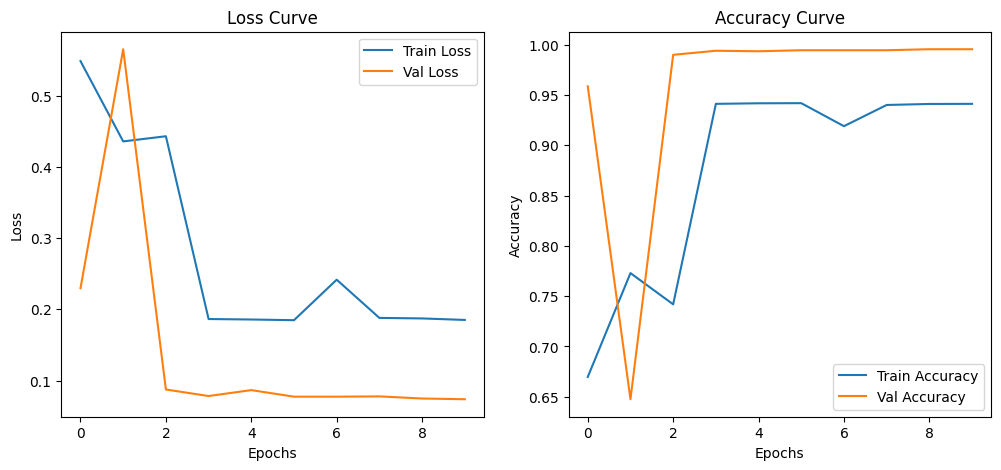

In [ ]:
# Plot Loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss') # Access loss using history.history['loss']
plt.plot(history.history['val_loss'], label='Val Loss') # Access val_loss using history.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy') # Access accuracy using history.history['accuracy']
plt.plot(history.history['val_accuracy'], label='Val Accuracy') # Access val_accuracy using history.history['val_accuracy']
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


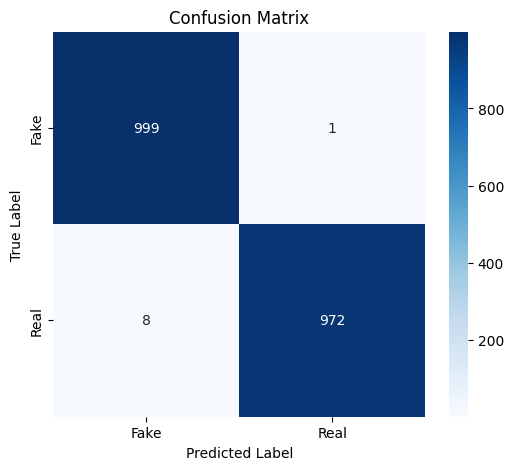

Classification Report:
               precision    recall  f1-score   support

        Fake       0.99      1.00      1.00      1000
        Real       1.00      0.99      1.00       980

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



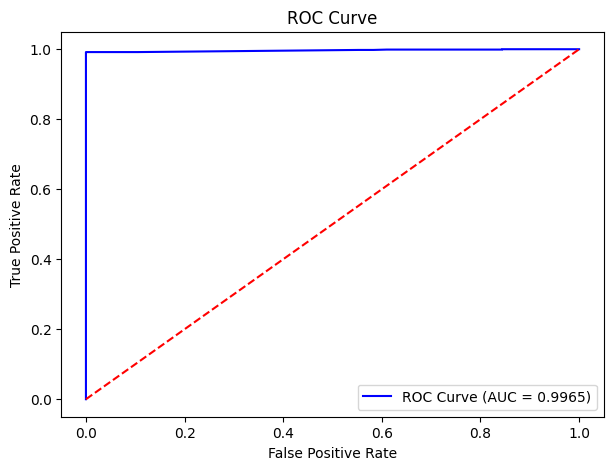

In [ ]:
# ... (previous code) ...

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Get predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Now you can generate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ... (rest of the code) ...
# ================================
# 📝 Classification Report
# ================================
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

# ================================
# 📈 ROC Curve (Only if Binary Classification)
# ================================
if len(np.unique(y_test)) == 2:  # Ensure binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])  # Use second column (probability of 'Real' class)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random classifier
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()